In [1]:
!pip install -q -U keras-tuner

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import kerastuner as kt
from  IPython import display
import pathlib
import shutil
import tempfile

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
data = pd.read_csv('/content/gdrive/My Drive/TSLA.csv', date_parser = True)

In [5]:
data.shape

(2704, 7)

In [6]:
data_training = data[data['Date']<'2020-01-01'].copy()
data_test = data[data['Date']>='2020-01-01'].copy()

In [7]:
data_training = data_training.drop(['Date', 'Adj Close'], axis = 1)
data_test = data_test.drop(['Date', 'Adj Close'], axis = 1)

In [8]:
data_test[-1:]

,Open,High,Low,Close,Volume
2703,613.0,645.5,609.5,640.390015,39150700


In [9]:
set_batch_size=60
day_interval=60

In [10]:
#epochs_size = data_training.shape[0]//set_batch_size
epochs_size = 50

In [11]:
past_30_days = data_training.tail(day_interval)
df = past_30_days.append(data_test)

In [12]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)

In [13]:
train_size = data_training.shape[0]
print(train_size)

2394


In [14]:
X_train = []
y_train = []

for i in range(day_interval, data_training.shape[0]):
    X_train.append(data_training[i-day_interval:i])
    y_train.append(data_training[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
X_train.shape

(2334, 60, 5)

In [16]:
y_train.shape

(2334,)

In [17]:
#model = keras.models.Sequential([
#    tf.keras.layers.LSTM(60, activation = 'relu', unroll= True, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])),
#    tf.keras.layers.LSTM(60, activation = 'relu', unroll= True, return_sequences = True),
#    #tf.keras.layers.LSTM(60, activation = 'relu', unroll= True, return_sequences = True),
#    tf.keras.layers.LSTM(60, activation = 'relu'),
#    keras.layers.Dense(1),
#])

In [18]:
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.LSTM(units=hp_units, activation='relu', unroll= True, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
  model.add(keras.layers.LSTM(units=hp_units, activation='relu', unroll= True, return_sequences = True,))
  model.add(keras.layers.LSTM(units=hp_units, activation='relu', unroll= True, return_sequences = True,))
  model.add(keras.layers.LSTM(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics=['mse'])

  return model

In [19]:
#model.summary()

In [20]:
tuner = kt.Hyperband(model_builder,
            objective='val_loss',
            max_epochs=10,
            factor=3,
            directory='my_dir',
            project_name='stock_prediction')

INFO:tensorflow:Reloading Oracle from existing project my_dir/stock_prediction/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/stock_prediction/tuner0.json


In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [22]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 0.001.



In [23]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
59/59 [==============================] - 32s 171ms/step - loss: 0.0301 - mse: 0.0537 - val_loss: 0.0021 - val_mse: 0.0059
Epoch 2/50
59/59 [==============================] - 7s 119ms/step - loss: 7.9541e-04 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0051
Epoch 3/50
59/59 [==============================] - 7s 120ms/step - loss: 6.5854e-04 - mse: 0.0015 - val_loss: 0.0020 - val_mse: 0.0057
Epoch 4/50
59/59 [==============================] - 7s 116ms/step - loss: 6.3777e-04 - mse: 0.0014 - val_loss: 0.0016 - val_mse: 0.0044
Epoch 5/50
59/59 [==============================] - 7s 117ms/step - loss: 5.4044e-04 - mse: 0.0012 - val_loss: 0.0016 - val_mse: 0.0045
Epoch 6/50
59/59 [==============================] - 7s 119ms/step - loss: 5.6348e-04 - mse: 0.0013 - val_loss: 0.0014 - val_mse: 0.0039
Epoch 7/50
59/59 [==============================] - 7s 124ms/step - loss: 5.1423e-04 - mse: 0.0012 - val_loss: 0.0023 - val_mse: 0.0066
Epoch 8/50
59/59 [==============================] -

In [24]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/7
59/59 [==============================] - 32s 171ms/step - loss: 0.0334 - mse: 0.0574 - val_loss: 0.0020 - val_mse: 0.0056
Epoch 2/7
59/59 [==============================] - 7s 120ms/step - loss: 7.7736e-04 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0050
Epoch 3/7
59/59 [==============================] - 7s 116ms/step - loss: 6.7912e-04 - mse: 0.0016 - val_loss: 0.0023 - val_mse: 0.0064
Epoch 4/7
59/59 [==============================] - 7s 118ms/step - loss: 5.6600e-04 - mse: 0.0013 - val_loss: 0.0016 - val_mse: 0.0045
Epoch 5/7
59/59 [==============================] - 7s 114ms/step - loss: 6.2422e-04 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0043
Epoch 6/7
59/59 [==============================] - 7s 115ms/step - loss: 6.0899e-04 - mse: 0.0014 - val_loss: 0.0019 - val_mse: 0.0055
Epoch 7/7
59/59 [==============================] - 7s 117ms/step - loss: 5.5825e-04 - mse: 0.0013 - val_loss: 0.0014 - val_mse: 0.0040


In [25]:
#logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
#model.compile(
#    loss='mse', # keras.losses.mean_squared_error
#    optimizer=keras.optimizers.Adam(learning_rate=0.003),
#)

#training_history = model.fit(
#    X_train,
#    y_train,
#    epochs=epochs_size,
#    batch_size=set_batch_size,
#    callbacks=[tensorboard_callback]
#)

In [27]:
#print("Average test loss: ", np.average(training_history.history['loss']))

In [28]:
inputs = scaler.fit_transform(df)
inputs.shape

(370, 5)

In [29]:
X_test = []
y_test = []

for i in range(day_interval, inputs.shape[0]):
    X_test.append(inputs[i-day_interval:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((310, 60, 5), (310,))

In [30]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

10/10 [==============================] - 0s 19ms/step - loss: 0.0022 - mse: 0.0051
[test loss, test accuracy]: [0.00223805895075202, 0.00507506774738431]


In [31]:
y_pred = model.predict(X_test)

In [32]:
y_pred.shape

(310, 1)

In [33]:
#Put last 60 day price to a input
tmr = np.array([inputs[-60:]])
tmr.shape

(1, 60, 5)

In [34]:
#denormalization
scale = 1/scaler.scale_[0]
scale

845.4200060000001

In [35]:
#denormalization
y_pred = y_pred*scale
y_test = y_test*scale

In [36]:
y_pred.shape,y_test.shape

((310, 1), (310,))

In [37]:
#Last of data
y_test[-1]

567.040001

In [38]:
#Last of chart predict result
y_pred[-1][0]

595.785

In [39]:
print("the next day price")
print(model.predict(tmr)[0][0]*scale)

the next day price
582.6138195759793


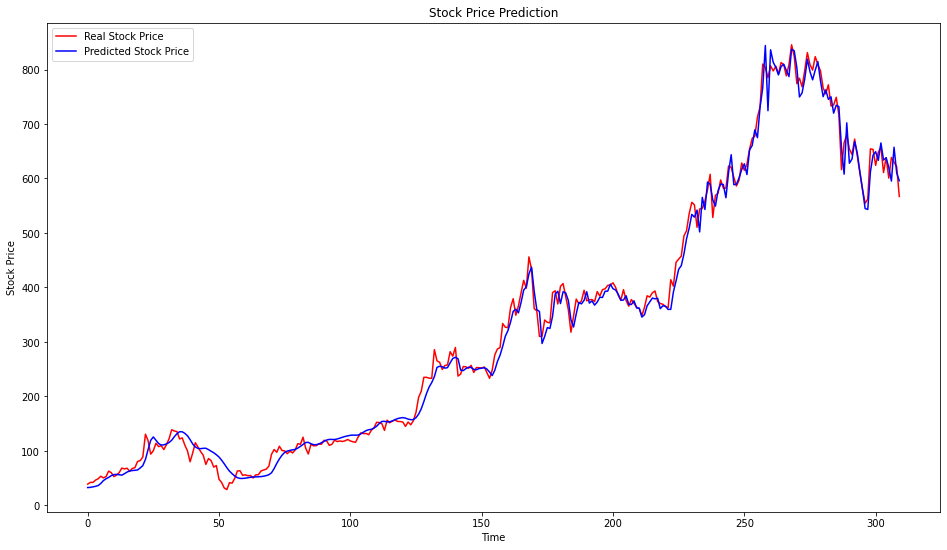

In [40]:
# Visualising the results
plt.figure(figsize=(16,9))
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [41]:
!kill 303
%load_ext tensorboard
%tensorboard --logdir logs/scalars

/bin/bash: line 0: kill: (303) - No such process


Reusing TensorBoard on port 6006 (pid 3311), started 1:44:40 ago. (Use '!kill 3311' to kill it.)

<IPython.core.display.Javascript object>